
# Working with coolers

In this notebook, we use files generated by the workflow `master_workflow` that, in short does:

1) Download the data from the source
2) Index the reference genome with `bwa index` and `samtools faidx`
3) Align the reads to the reference genome with `bwa mem`
4) Pair and sort the reads to `.pairs` files with `pairtools parse | pairtools sort`
5) Deduplicate the pairs with `pairtools dedup`
6) Convert the .pairs to cooler files with `cooler cload pairs`

We will:

1) Load the cooler files
2) Merge the coolers from the same BioSample ID --> Create 'replicates'
3) Zoomify the merged cooler files (coarsen) to create a multicooler (.mcool) file
4) Balance the matrices (use commandline `cooler balance`)
5) Calculate E1 compartments with `cooltools compute_cis_eig`

## Overview

### Data (Accessions)

In [116]:
#| echo: false

import pandas as pd

df = pd.read_csv('../data/SraRunTable.txt')[['source_name','Run', 'BioSample', 'Bases','Bytes']].sort_values(['source_name', 'Run'])
df['GB'] = df['Bytes'].apply(lambda x: x / (1024 ** 3))
df['Reads'] = df['Bases']/300
df = df[['source_name', 'BioSample', 'Run', 'GB', 'Bases', 'Reads']]

# Use the style method to format the columns for display
df1 = df.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})

df_grouped = df.groupby('source_name').agg({'GB': 'sum', 'Bases': 'sum', 'Reads': 'sum'}).reset_index()

display(df1, df_grouped)


,source_name,BioSample,Run,GB,Bases,Reads
16,fibroblast,SAMN08375237,SRR6502335,29.771059,"73,201,141,800","244,003,806"
17,fibroblast,SAMN08375237,SRR6502336,22.755361,"65,119,970,100","217,066,567"
18,fibroblast,SAMN08375236,SRR6502337,21.434722,"52,769,196,300","175,897,321"
19,fibroblast,SAMN08375236,SRR6502338,21.420030,"52,378,949,100","174,596,497"
20,fibroblast,SAMN08375236,SRR6502339,10.207410,"28,885,941,600","96,286,472"
9,fibroblast,SAMN08375237,SRR7349189,52.729173,"139,604,854,200","465,349,514"
10,fibroblast,SAMN08375236,SRR7349190,53.085520,"142,008,353,400","473,361,178"
21,pachytene spermatocyte,SAMN08375234,SRR6502342,60.258880,"150,370,993,500","501,236,645"
22,pachytene spermatocyte,SAMN08375234,SRR6502344,27.146048,"65,697,684,300","218,992,281"
23,pachytene spermatocyte,SAMN08375234,SRR6502345,26.202707,"63,490,538,700","211,635,129"


,source_name,GB,Bases,Reads
0,fibroblast,211.403275,553968406500,1.846561e+09
1,pachytene spermatocyte,274.835160,715656614700,2.385522e+09
2,round spermatid,243.128044,655938457200,2.186462e+09
3,sperm,164.131640,428913635400,1.429712e+09
4,spermatogonia,192.794420,518665980300,1.728887e+09


### Folder structure

In [1]:
#| echo: false

!tree -d -L 2 ../steps/bwa/PE

../steps/bwa/PE
├── bamfiles
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
├── cool
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
└── pairs
    ├── fibroblast
    ├── pachytene_spermatocyte
    ├── round_spermatid
    ├── sperm
    └── spermatogonia

18 directories


## FullMerge (pool all from each source_name)

With `cooler merge`. 

We will trust Wang et al. 2019 when they say that compartments are highly reprocible between replicates.

Thus, we will merge all samples from the same source_name into a single cooler file.

**Overview:** 
- Locate the coolers (`glob` --> dictionary)
- Merge the coolers (`cooler.merge_coolers`)
- Zoomify the merged cooler (`cooler.zoomify_cooler`) to resolutions: 10kb, 50kb, 100kb, 500kb. 
- Balance the matrices (`!cooler balance`) (use the CLI, as it is more easily parallelized)

### Create cooler dictionary (`glob`) 

In [1]:
import glob
import os.path as op
from pprint import pprint as pp

# Get the list of cell type dirs
base_dir = '../steps/bwa/PE/cool'
folders = glob.glob(op.join(base_dir, '*'))

files_dict = {f:glob.glob(f"{f}/*.nodups.*") for f in folders}
cooler_dict = {op.basename(k): [op.basename(f) for f in v] for k,v in files_dict.items()}
pp(cooler_dict)

{'fibroblast': ['SRR6502339.nodups.10000.cool',
                'SRR7349190.nodups.10000.cool',
                'SRR7349189.nodups.10000.cool',
                'SRR6502335.nodups.10000.cool',
                'SRR6502338.nodups.10000.cool',
                'SRR6502336.nodups.10000.cool',
                'SRR6502337.nodups.10000.cool'],
 'pachytene_spermatocyte': ['SRR7345459.nodups.10000.cool',
                            'SRR6502344.nodups.10000.cool',
                            'SRR6502342.nodups.10000.cool',
                            'SRR7345458.nodups.10000.cool',
                            'SRR6502345.nodups.10000.cool',
                            'SRR7349191.nodups.10000.cool'],
 'round_spermatid': ['SRR7349192.nodups.10000.cool',
                     'SRR6502353.nodups.10000.cool',
                     'SRR6502352.nodups.10000.cool',
                     'SRR6502351.nodups.10000.cool',
                     'SRR7345460.nodups.10000.cool',
                     'SRR7345461.nodu

### Merge coolers

We iterate through the dictionary and merge the coolers with `cooler merge`.

The `mergebuf` parameter should be adjusted if you don't have 32G memory. Default: `mergebuf = 20000000`.

Below, we also check if the output file already exists. If it does, we skip the merge.

In [5]:
# NB adjust `mergebuf` if you don't have 32G of RAM

import cooler

for folder,cooler_list in cooler_dict.items():
    in_uris = [op.join(base_dir, folder, file) for file in cooler_list]
    out_uri = op.join(base_dir, folder, f'{folder}.fullmerge.cool')

    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Creating {out_uri} by \nMerging {len(cooler_list)} coolers into one:", end=" ")
    print("\t",[file.split('.')[0] for file in cooler_list])
    cooler.merge_coolers(output_uri=out_uri,
                         input_uris=in_uris,
                         mergebuf=int(5e7),
                         )
    print("... Done!")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.fullmerge.cool: exists...


### Zoomify the merged cooler files

Here, we zoomify the merged cooler files to resolutions: 10kb, 50kb, 100kb, 500kb.

In [7]:
# NB 8 cores and 32G of RAM was used

import glob
import cooler
import os.path as op

base_dir = '../steps/bwa/PE/cool'
merged_coolers = glob.glob(op.join(base_dir, '*/*.fullmerge.cool'))


for clr in merged_coolers:
    out_uri = clr.replace('.fullmerge.cool', '.mcool')
    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Zoomifying cooler: \n\t   {clr}\n\t-> {out_uri}", end="")
    
    cooler.zoomify_cooler(base_uris = clr,
                          outfile = out_uri,
                          resolutions = [10000,50000,100000,500000],
                          chunksize = 10000000,
                          nproc = 8)
    print(" --> done")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.mcool: exists...
Zoomifying cooler: 
	   ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool
	-> ../steps/bwa/PE/cool/fibroblast/fibroblast.mcool --> done
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool: exists...


In [19]:
import glob
mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")

for mcool in mcools:
    print(f"{mcool}:")
    print(cooler.fileops.list_coolers(mcool))
    print()



../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/sperm/sperm.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/fibroblast/fibroblast.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']



0    chr1
Name: chrom, dtype: category
Categories (22, object): ['chr1' < 'chr2' < 'chr3' < 'chr4' ... 'chr19' < 'chr20' < 'chrX' < 'chrY']

0    0
Name: start, dtype: int32

0    500000
Name: end, dtype: int32

0    0.002814
Name: weight, dtype: float64

### Balance the matrices

In [2]:
%capture --no-stdout

import glob

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
resolutions = [10000, 50000, 100000, 500000]

for mcool in mcools:
    print(f"Balancing {mcool}:")
    for res in resolutions:
        full_name = f"{mcool}::resolutions/{res}"
        print(f"\tresolution {res}...", end=" ")
        # First, just default values
        #!cooler balance -p 32 {full_name}
        # With more filtering
        !cooler balance -p 32 -c 20000000 --cis-only -n cis_weights {full_name}
        print("--> Done!")

Balancing ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
	resolution 10000... 

INFO:cooler.cli.balance:Balancing "../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool::resolutions/10000"
INFO:cooler.balance:variance is 2079661.4027216053
INFO:cooler.balance:variance is 453553.06527791504
INFO:cooler.balance:variance is 122090.58632047936
INFO:cooler.balance:variance is 129190.84140421994
INFO:cooler.balance:variance is 48191.01921909741
INFO:cooler.balance:variance is 40764.260723976775
INFO:cooler.balance:variance is 18356.248248008043
INFO:cooler.balance:variance is 13507.74990364802
INFO:cooler.balance:variance is 6807.56897366601
INFO:cooler.balance:variance is 4602.949620233886
INFO:cooler.balance:variance is 2481.4615818257016
INFO:cooler.balance:variance is 1594.394282252964
INFO:cooler.balance:variance is 894.8193883950739
INFO:cooler.balance:variance is 557.6097513200839
INFO:cooler.balance:variance is 320.5395715985926
INFO:cooler.balance:variance is 196.1207825649443
INFO:cooler.balance:variance is 114.360455989492
INFO:cooler.balance:variance is

## RepMerge (pool all from each BioSample ID)

Merge into the original 'replicates' 

In [1]:
#df.groupby(['source_name','BioSample'])['Reads'].sum()

In [2]:
# from pprintpp import pprint as pp

# grouped_df = df.groupby(['source_name','BioSample'])

# # Initialize an empty dictionary
# rep_dict = {}

# # Iterate over each group
# for (source_name, BioSample), group in grouped_df:
#     # Extract the 'Run' column and convert it to a list
#     run_list = group['Run'].tolist()
    
#     # Populate the nested dictionary
#     if source_name not in rep_dict:
#         rep_dict[source_name] = {}
#     rep_dict[source_name][BioSample] = run_list

# pp(rep_dict)

In [3]:
# for source_name, BioSample_dict in rep_dict.items():
#     print(f"source_name: {source_name}")
#     print(f"Changing working dir: {source_name}/")
#     for BioSample, run_list in BioSample_dict.items():
#         print(f"Merging samples for BioSample: {BioSample}: {run_list}")

# Plotting

## 500kb resolution

### Example with a single sample

#### Imports

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [2]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools

#### Load cooler

In [3]:
cool_file = "../steps/bwa/PE/cool/fibroblast/fibroblast.mcool"

clr = cooler.Cooler(f"{cool_file}::resolutions/500000")

#### Calculate gc covariance (from the reference genome)

In [4]:
import bioframe
import os

bins = clr.bins()[:]
rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
gc_cov_csv = '../steps/rheMac10_gc_cov_500kb.tsv'
if not os.path.exists(gc_cov_csv):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(gc_cov_csv, index=False, sep='\t')
    display(gc_cov)
else: 
    print("Already exists, just read from file:")
    gc_cov = pd.read_csv(gc_cov_csv, sep='\t')
    display(gc_cov)

Already exists, just read from file:


,chrom,start,end,GC
0,chr1,0,500000,0.424508
1,chr1,500000,1000000,0.378836
2,chr1,1000000,1500000,0.388272
3,chr1,1500000,2000000,0.445226
4,chr1,2000000,2500000,0.439485
...,...,...,...,...
5715,chrY,9500000,10000000,0.399518
5716,chrY,10000000,10500000,0.396028
5717,chrY,10500000,11000000,0.395280
5718,chrY,11000000,11500000,0.382006


In [5]:
# Apparently, we have som NaN values, I don't know why (and only 1 on the X)
gc_cov[gc_cov['GC'].isna()].groupby('chrom').size()

chrom
chr1     1
chr10    1
chr11    1
chr12    1
chr13    1
chr14    1
chr15    1
chr16    1
chr17    1
chr18    1
chr19    1
chr2     1
chr20    1
chr3     1
chr4     1
chr5     1
chr6     1
chr7     1
chr8     1
chr9     1
chrY     1
dtype: int64

In [6]:
# Make the full view frame
view_df = pd.DataFrame(
    {
    'chrom': clr.chromnames,
    'start': 0,
    'end': clr.chromsizes.values,
    'name': clr.chromnames
    }
                      )
#display(view_df)

In [7]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
len(eigenvector_track)

5720

In [8]:
# full track
eigenvector_track

,chrom,start,end,E1
0,chr1,0,500000,-0.756052
1,chr1,500000,1000000,-1.001063
2,chr1,1000000,1500000,-0.928042
3,chr1,1500000,2000000,-0.507579
4,chr1,2000000,2500000,0.123708
...,...,...,...,...
5715,chrY,9500000,10000000,-0.499798
5716,chrY,10000000,10500000,-0.588820
5717,chrY,10500000,11000000,-0.988677
5718,chrY,11000000,11500000,-0.566585


In [9]:
# subset the chrX   
eigenvector_track_chrX = eigenvector_track.loc[eigenvector_track['chrom'] == 'chrX']
nbins = len(eigenvector_track_chrX)
eigenvector_track_chrX
e1X_values = eigenvector_track_chrX['E1'].values

In [10]:
# Where does the E1 change sign
np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]

array([  1,   6,  16,  26,  29,  40,  42,  49,  54,  55,  59,  60,  61,
        62,  74,  83,  86, 101, 102, 103, 104, 108, 123, 124, 129, 138,
       141, 142, 147, 149, 185, 188, 194, 196, 197, 201, 206, 209, 211,
       215, 222, 224, 228, 233, 238, 240, 250, 253, 256, 265, 273, 274,
       288, 289, 290, 293, 296, 302])

#### Plot E1 and matrix

In [56]:
%%capture chrX_matrix_e1_500kb

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.05, sharex=ax)
#weights = clr.bins()[:]['weight'].values
#ax1.plot([0,nbins],[0,0],'k',lw=0.25)

#ax1.plot(e1X_values, label='E1')

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

ax1.set_ylabel('E1')
ax1.set_xticks([]);


for i in np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]:
    # Horisontal lines where E1 intersects 0
    ax.plot([0,nbins],[i,i],'k',lw=0.4)

    # Vertical lines where E1 intersects 0
    ax.plot([i,i],[0,nbins],'k',lw=0.4)

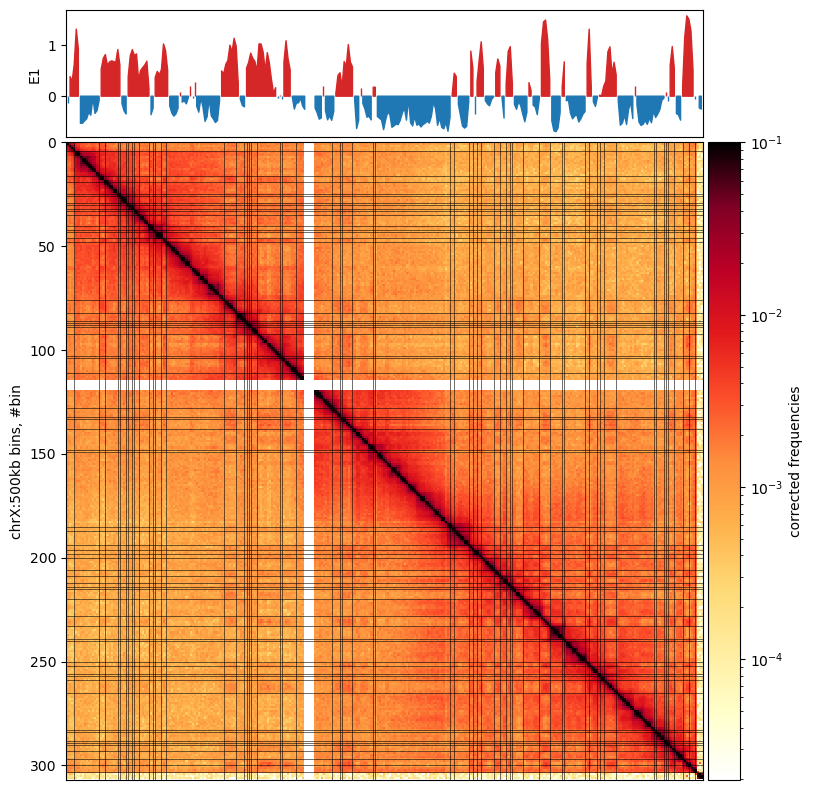

In [57]:
#| label: chrX-matrix-e1-500kb
#| fig-cap: "chrX interaction matrix with E1 eigenvector values. 500kb resolution"

chrX_matrix_e1_500kb()

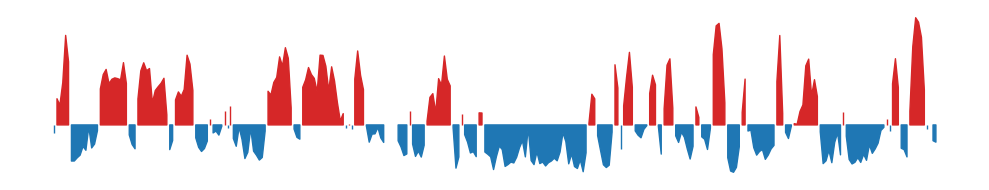

In [13]:
#| label: chrX-e1-500kb-plot
#| fig-cap: "500kb binned E1 eigenvector values for chrX. Freshly calculated from the cooler file."
#| fig-height: 1


import matplotlib.pyplot as plt

f, ax1 = plt.subplots(
    figsize=(10, 2),
)

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='C0')

#ax1.set_ylabel('E1')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.tight_layout()

# Save the plot as a SVG file
#plt.savefig('e1_plot.svg', bbox_inches='tight')

plt.show()

#### Stairs plot of the E1 compartments

(Less spiky, more smooth)



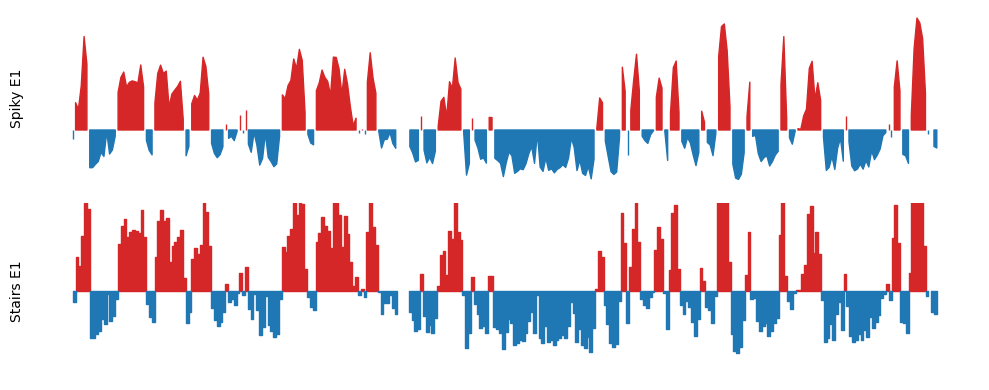

In [ ]:
#| label: chrX-e1-500kb-stairs
#| fig-cap: "500kb binned E1 eigenvector values for chrX."
#| fig-height: 2


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1,
    figsize=(10, 4)
)

chrom_start = eigenvector_track_chrX['start'].values
window_size = chrom_start[1] - chrom_start[0]

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

# Create stairs
x = np.zeros(2*chrom_start.size)
y = np.zeros(2*chrom_start.size)
x[0::2] = chrom_start
x[1::2] = chrom_start + window_size
y[0::2] = e1X_values
y[1::2] = e1X_values

# Layout
ax1.set_ylabel('Spiky E1')
ax2.set_ylabel('Stairs E1')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-1, 1)

# Remove borders
ax1.spines[:].set_visible(False)
ax2.spines[:].set_visible(False)

ax2.fill_between(x, y, 0, where=(y > 0), color='tab:red')
ax2.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

plt.tight_layout()
# Save the plot as a high-resolution PNG file
#plt.savefig('../steps/e1_plot.png', dpi=320, bbox_inches='tight')



### All 5 full merges

#### Load coolers

In [14]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/500000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs = {key: clrs[key] for key in chron_order}
clrs

{'fibroblast': <Cooler "fibroblast.mcool::/resolutions/500000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/500000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/500000">,
 'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/500000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/500000">}

#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [15]:
# Try with only the gc_cov for chrX

import bioframe
import pandas as pd
import os.path as op

bins = clrs['fibroblast'].bins().fetch('chrX')[:]
out_name = '../steps/rheMac10_gc_cov_X_500kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   307 non-null    object 
 1   start   307 non-null    int64  
 2   end     307 non-null    int64  
 3   GC      307 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.7+ KB
None


#### Calculate the E1 compartments

Loop: view_df, cis_eigs, e1_values

##### Plot GC covariance

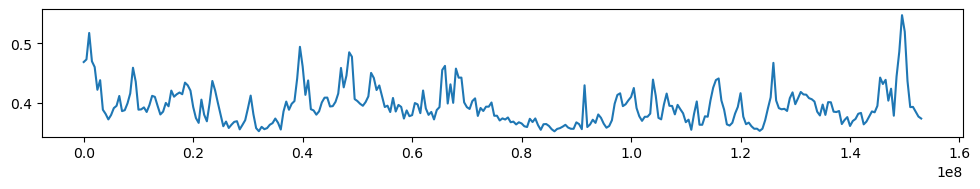

In [16]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(
    figsize=(10, 2),
)

ax.plot(gc_cov['start'],gc_cov['GC'])

plt.tight_layout()

##### Chromosome restricted E1 compartments

In [17]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools
import pandas as pd

eigs_full = {}
e1_values_full = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Divide into chromosome arms
clr = clrs['fibroblast']
view_df_full = pd.DataFrame(
    {
    'chrom': 'chrX',
    'start': 0,
    'end': chrX_size,
    'name': 'chrX'
    }, index=[0]
                      )

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}, size {clr.binsize}")
    cis_eigs_full = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df_full,
                        n_eigs=3,
                        )
    eigs_full[name] = cis_eigs_full[1]
    e1_track_full = cis_eigs_full[1][['chrom','start','end','E1']]
    e1_values_full[name] = e1_track_full['E1'].values

#eigs

Calculating eigenvectors for fibroblast, size 500000
Calculating eigenvectors for spermatogonia, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Chromosome arms restricted

In [18]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools
import pandas as pd

eigs = {}
e1_values = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Divide into chromosome arms
view_df = pd.DataFrame(
    {
    'chrom': 'chrX',
    'start': [0, 59_000_001],
    'end': [59_000_000, chrX_size],
    'name': ['X_short', 'X_long']
    }, index=[0,1]
                      )

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}")
    cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
    eigs[name] = cis_eigs[1]
    e1_track = cis_eigs[1][['chrom','start','end','E1']]
    e1_values[name] = e1_track['E1'].values

#eigs

Calculating eigenvectors for fibroblast
Calculating eigenvectors for spermatogonia


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid
Calculating eigenvectors for sperm


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Refined: 10Mb windows restricted

In [19]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools

eigs_10mb = {}
e1_values_10mb = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Calculate in 1Mb windows
# Define the window size (1Mb)

window_size = 10_000_000

# Generate the start and end positions for each window
start_positions = list(range(0, chrX_size, window_size))
end_positions = [min(start + window_size, chrX_size) for start in start_positions]
# Create the DataFrame
view_df_10mb = pd.DataFrame({
    'chrom': ['chrX'] * len(start_positions),
    'start': start_positions,
    'end': end_positions,
    'name': [f'X_{i}' for i in range(len(start_positions))]
})
#display(view_df)

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}")
    cis_eigs_10mb = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df_10mb,
                        n_eigs=3,
                        )
    eigs_10mb[name] = cis_eigs_10mb[1]
    e1_track_10mb = cis_eigs_10mb[1][['chrom','start','end','E1']]
    e1_values_10mb[name] = e1_track_10mb['E1'].values

#eigs

Calculating eigenvectors for fibroblast


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Plot NaN histogram

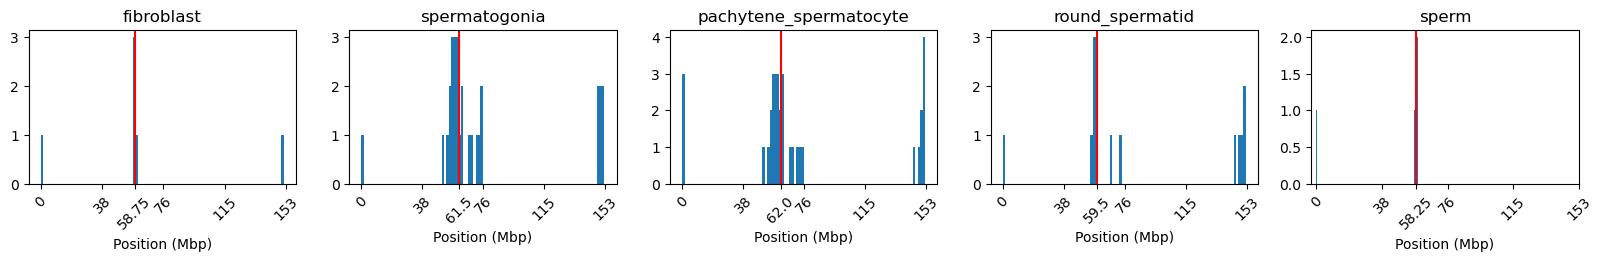

In [20]:
#| label: e1_nan_hist
#| fig-cap: "Histogram of NaN values in the E1 eigenvector for each cell type."
#| column: page-inset

# Check the number of NaN values in the E1 column
import numpy as np

# Check the number of NaN values in the E1 column and create a DataFrame
nan_counts = {k: {'length': len(v), 'NaNs': np.isnan(v).sum()} for k, v in e1_values.items()}
#display(pd.DataFrame.from_dict(nan_counts, orient='index'))

# Locate the NaN values (histogram)
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 5, figsize=(20,2))
for i, (name, track) in enumerate(eigs.items()):
    e1 = track['E1'].values
    # Locate NaN values
    e1_nan = np.where(np.isnan(e1))
    # Plot histogram
    ax[i].hist(e1_nan, bins=100)
    
    # Plot median line
    median_pos = np.median(e1_nan)
    ax[i].axvline(median_pos, color='r')

    # Layout
    ax[i].set_title(name)
    xticks = np.linspace(0, len(e1), num=5)
    xticks = np.append(xticks, median_pos)  # Add median position to xticks
    ax[i].set_xticks(xticks)
    xticklabels = np.linspace(0, len(e1) * 0.5, num=5, dtype = 'int').tolist()
    xticklabels.append(median_pos*0.5)  # Add median label
    ax[i].set_xticklabels(xticklabels, rotation=45)
    ax[i].set_xlabel('Position (Mbp)')
                     

#### Plot the E1 compartments

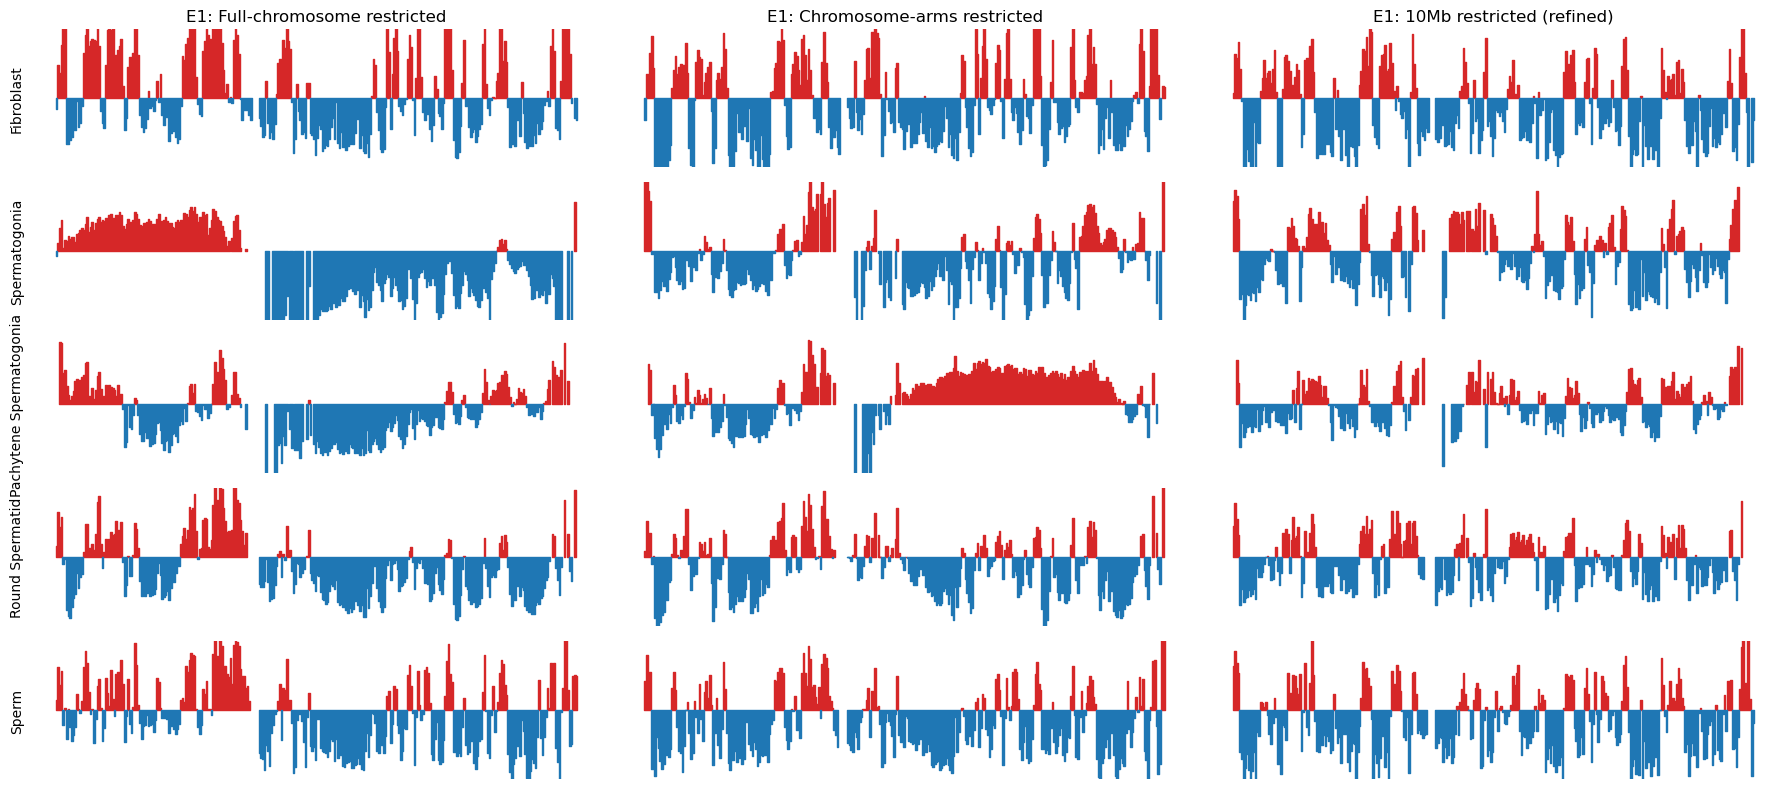

In [21]:
#| label: e1-fullmerged-all-500kb
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution. Left: Chromosome-arm restricted E1. Right: 10Mb window restricted E1."
#| column: page-inset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

names_abbr = {'fibroblast': 'Fibroblast', 'spermatogonia': 'Spermatogonia', 'pachytene_spermatocyte': 'Pachytene Spermatogonia', 'round_spermatid': 'Round Spermatid', 'sperm': 'Sperm'}

chrom_start = e1_track_full['start'].values
chrom_end = e1_track_full['end'].values-1

f, axs = plt.subplots(5, 3, figsize=(18, 8), sharex=True, sharey=True)

# Populate the first column
axs[0,0].set_title('E1: Full-chromosome restricted')
for i, (name, e1) in enumerate(e1_values_full.items()):
    ax = axs[i,0]
    ax.set_ylabel(names_abbr[name])

    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

# Populate the second column
axs[0,1].set_title('E1: Chromosome-arms restricted')
for i, (name, e1) in enumerate(e1_values.items()):
    ax = axs[i,1]
    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

# Populate the third column
axs[0,2].set_title('E1: 10Mb restricted (refined)')
for i, (name, e1) in enumerate(e1_values_10mb.items()):
    ax = axs[i,2]
    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    

# Set y-limits for all subplots
for ax in axs.flat:
    ax.set_ylim(-0.8, 0.8)
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('../steps/e1_plot_full.svg', bbox_inches='tight')

#### Plot matrices with compartments (round spermatid)

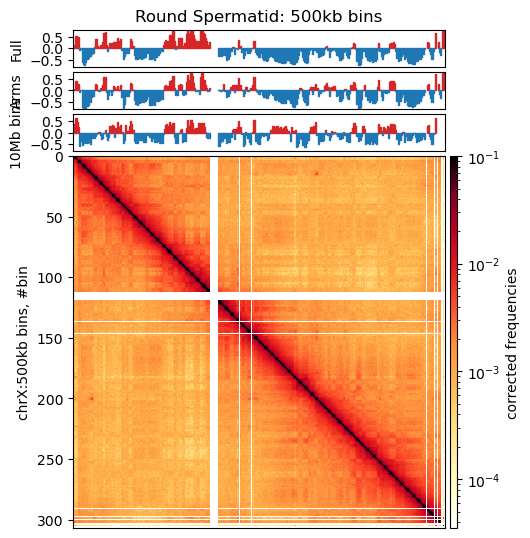

In [63]:
#| label: e1-matrix-500kb-full-arms-10mb-round_spermatid
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution for round spermatid, as well as the interaction matrix. E1 was restricted to top: Full-chromosome, middle: Chromosome-arms, bottom: 10Mb window."


import cooltools.lib.plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan



clr = clrs['round_spermatid']
chrom_start, chrom_end = e1_track_full['start'].values, e1_track_full['end'].values-1
e1 = e1_values_10mb['round_spermatid']
nbins = len(clr.bins().fetch('chrX'))

f, ax = plt.subplots(
    figsize=(8,5.5),
)

norm = LogNorm(vmax=0.1)


e1_list = [e1_values_10mb['round_spermatid'], e1_values['round_spermatid'], e1_values_full['round_spermatid']]
e1_names = ['10Mb bins', 'Arms', 'Full']
colors = ['tab:red', 'tab:blue', 'tab:green']



im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

for i, e1 in enumerate(e1_list):
    ax1 = divider.append_axes("top", size="10%", pad=0.05, sharex = ax)
    # weights = clr.bins()[:]['weight'].values

    # ax1.plot(e1, label='E1')

    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    #smooth_y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start/500_000
    x[1::2] = chrom_end/500_000
    y[0::2] = e1
    y[1::2] = e1
    # smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))['value'].values
    # smooth_y[0::2] = smooth_e1
    # smooth_y[1::2] = smooth_e1


    ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

    ax1.set_ylabel(e1_names[i])
    ax1.set_ylim(-0.8, 0.8)
    ax1.set_xticks([])

ax1.set_title('Round Spermatid: 500kb bins')


#    # Plot the sign changes on the matrix 
#     col = colors[i]
#     for i in np.where(np.diff( (pd.Series(e1)>0).astype(int)))[0]:
#         # Horisontal lines where E1 intersects 0
#         ax.plot([0,nbins],[i,i],col,lw=0.5)

#         # Vertical lines where E1 intersects 0
#         ax.plot([i,i],[0,nbins],col,lw=0.5)

plt.tight_layout()

#### Sliding window summed E1 compartments

To mimic the smoothing applied in the Wang et al. 2019 paper, where they slide a 400kb window in 100kb steps on the obs/exp matrix, we will similarly slide a 400kb window in 100kb steps directly on the E1 compartments.

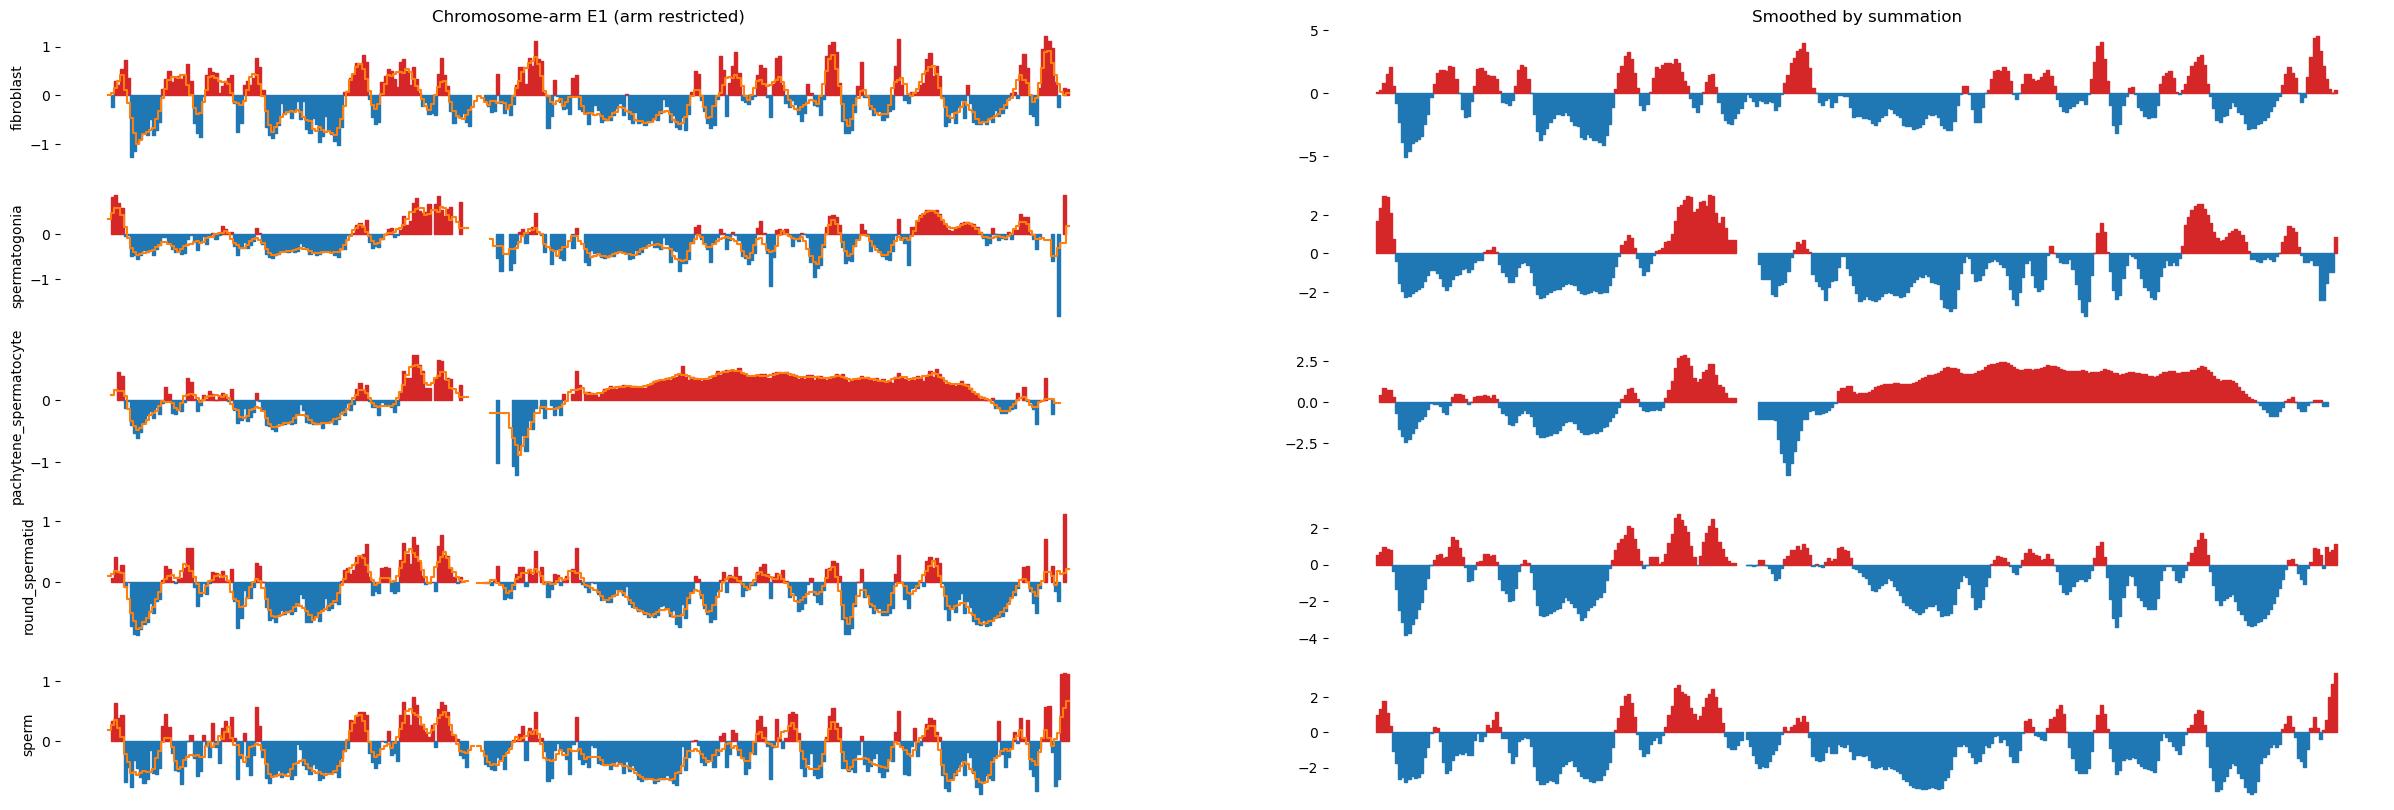

In [ ]:
#| label: e1-fullmerged-all-500kb-running-avg
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution with rolling summation, with window size 2.5Mb, step size 500Kb: Each value is now the sum of the surrounding n=5 bins."
#| column: body-outset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.signal.windows import triang

resolution = 500_000
window_size = 2_500_000
step_size = window_size // resolution

chrom_start = e1_track['start'].values
chrom_end = e1_track['end'].values-1

f, axs = plt.subplots(5, 2, figsize=(30, 10), sharex=True)

axs[0, 0].set_title('Chromosome-arm E1 (arm restricted)')
axs[0, 1].set_title('Smoothed by summation')

for i, (name, e1) in enumerate(e1_values.items()):
    # print(i, name, e1.size)
    smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))

    ax0 = axs[i, 0]
    ax1 = axs[i, 1]
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    smooth_y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1
    smooth_y[0::2] = smooth_e1['value'].values
    smooth_y[1::2] = smooth_e1['value'].values


    ax0.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax0.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    # Overlay the smoothed line (divided by 5 to make it a mean)
    ax0.plot(x, smooth_y/5, color='C1')

    ax1.fill_between(x, smooth_y, 0, where=(smooth_y > 0), color='tab:red')
    ax1.fill_between(x, smooth_y, 0, where=(smooth_y < 0), color='tab:blue')

    ax0.set_ylabel(name)
    ylim = 1.5
    #ax0.set_ylim(-ylim, ylim)
    #ax1.set_ylim(-ylim*4, ylim*4)

for ax in axs.flat:
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    #ax.set_yticks([])

# plt.tight_layout()

## 100kb resolution

### All 5 full merges

#### Load coolers

In [114]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/100000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs = {key: clrs[key] for key in chron_order}
clrs

names_abbr = {'fibroblast': 'Fibroblast', 'spermatogonia': 'Spermatogonia', 'pachytene_spermatocyte': 'Pachytene Spermatogonia', 'round_spermatid': 'Round Spermatid', 'sperm': 'Sperm'}


#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [115]:
# Try with only the gc_cov for chrX

import bioframe
import pandas as pd
import os.path as op

bins = clrs['fibroblast'].bins().fetch('chrX')[:]
out_name = '../steps/rheMac10_gc_cov_X_100kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   1534 non-null   object 
 1   start   1534 non-null   int64  
 2   end     1534 non-null   int64  
 3   GC      1533 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.1+ KB
None


#### Calculate the E1 compartments

Loop: view_df, cis_eigs, e1_values

##### Plot GC covariance

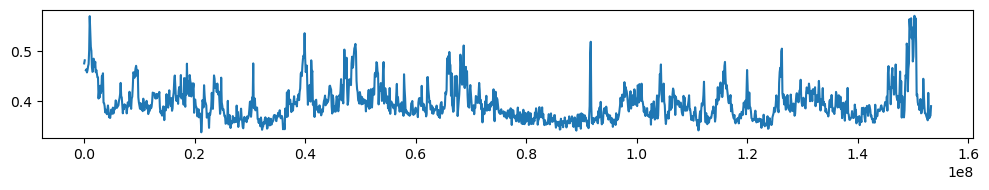

In [116]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 2))

ax.plot(gc_cov['start'],gc_cov['GC'])
plt.tight_layout()

##### Create viewframes: full, arms, 10Mb windows

In [117]:
import pandas as pd

# Fetch the chromsize of X from one of the coolers
chrX_size = clrs['fibroblast'].chromsizes['chrX']

views = {}

# Make the full view frame
views['full'] = pd.DataFrame({
    'chrom': 'chrX',
    'start': 0,
    'end': chrX_size,
    'name': 'chrX'}, index=[0])

# Divide into chromosome arms
views['arms'] = pd.DataFrame({
    'chrom': 'chrX',
    'start': [0, 59_000_001],
    'end': [59_000_000, chrX_size],
    'name': ['X_short', 'X_long']}, index=[0,1])

# Calculate in 10Mb windows
window_size = 10_000_000
start_positions = list(range(0, chrX_size, window_size))
end_positions = [min(start + window_size, chrX_size) for start in start_positions]

# Create the DataFrame
views['10Mb'] = pd.DataFrame({
    'chrom': ['chrX'] * len(start_positions),
    'start': start_positions,
    'end': end_positions,
    'name': [f'X_{i}' for i in range(len(start_positions))]
})

##### Calulate the E1 compartments

In [ ]:
import cooltools

eigs = {}
e1_values = {}

for name, clr in clrs.items():
    if name not in eigs or name not in e1_values:
        eigs[name] = {} 
        e1_values[name] = {}
    for view, view_df in views.items():
        print(f"Calculating eigenvectors for {name} at {view}")
        cis_eigs = cooltools.eigs_cis(
                            clr,
                            gc_cov,
                            view_df=view_df,
                            n_eigs=1)
        eigs[name][view] = cis_eigs[1]
        e1_values[name][view] = cis_eigs[1]['E1'].values
        


Calculating eigenvectors for fibroblast at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for fibroblast at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for fibroblast at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


#### Plot matrices with compartments

#### Plot the E1 compartments

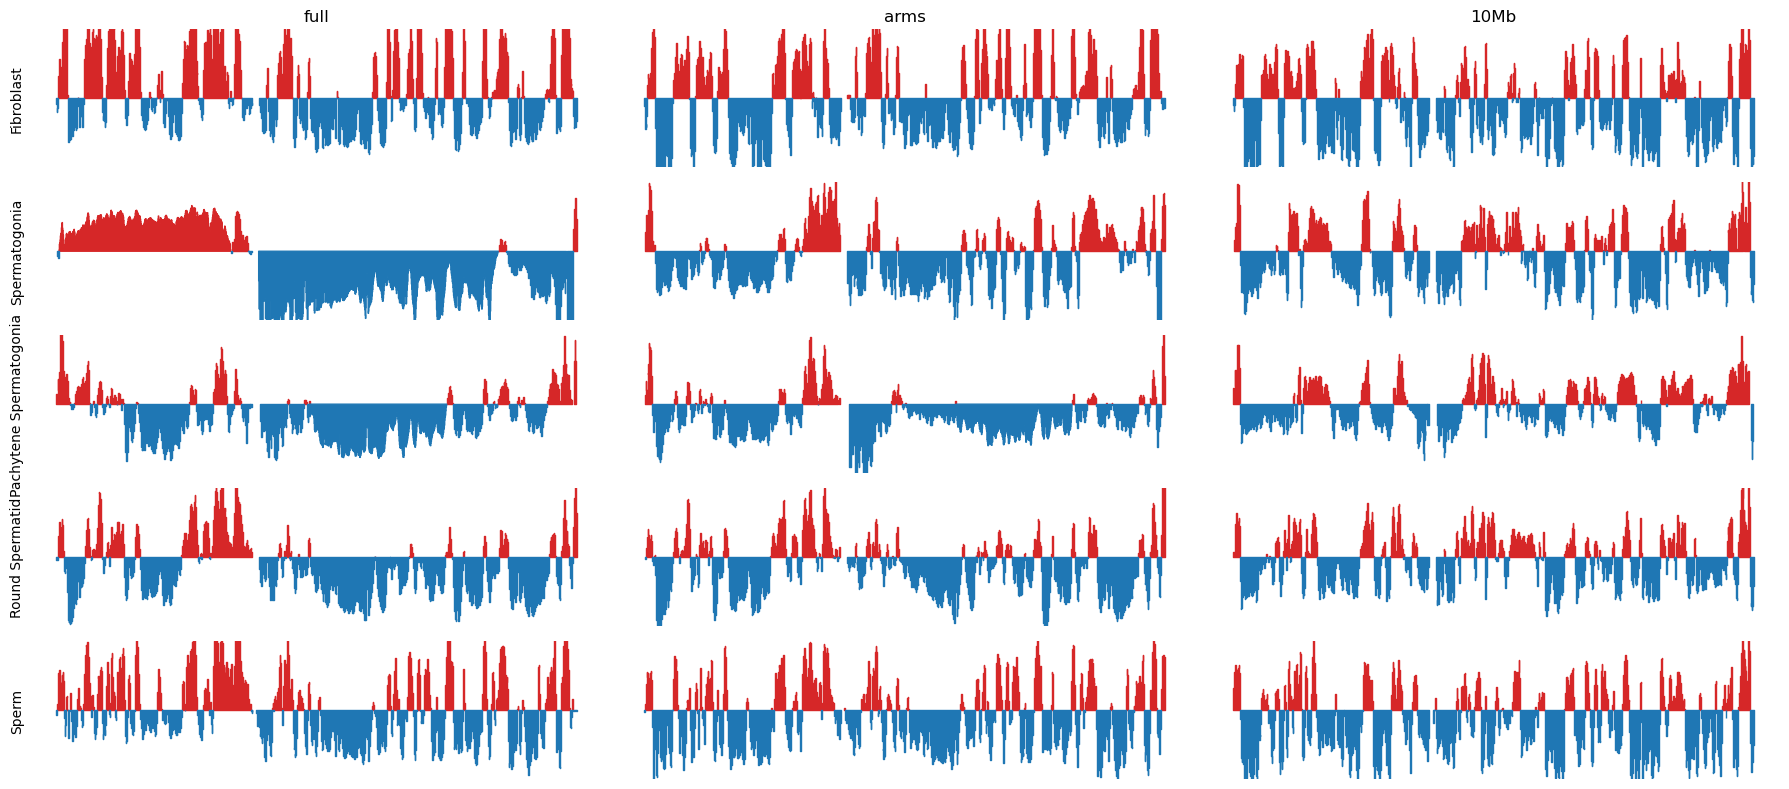

In [156]:
#| label: e1-fullmerged-all-100kb-5smoothed
#| fig-cap: "E1 eigenvector values for all merged samples at 100kb resolution. Left: Chromosomes (not restricted) Middle: Chromosome-arm restricted E1. Right: 10Mb window restricted E1.Values are smoothed with a sliding window of 5 bins, step size 1 bin."
#| column: page-inset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

chrom_start = e1_track['start'].values
chrom_end = e1_track['end'].values-1

f, axs = plt.subplots(5, 3, figsize=(18, 8), sharex=True, sharey=True)

# Loop through eigs and e1_values to plot the E1 values
for i, (name, e1_dict) in enumerate(e1_values.items()):
    axs[i,0].set_ylabel(names_abbr[name])
    for j, (view, e1) in enumerate(e1_dict.items()):
        ax = axs[i, j]

        if i==0:
            ax.set_title(view)

        # Create stairs
        x = np.zeros(2*chrom_start.size)
        y = np.zeros(2*chrom_start.size)
        smooth_y = np.zeros(2*chrom_start.size)
        x[0::2] = chrom_start
        x[1::2] = chrom_end
        y[0::2] = e1
        y[1::2] = e1
        smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))['value'].values
        smooth_y[0::2] = smooth_e1
        smooth_y[1::2] = smooth_e1


        #ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
        #ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
        #ax.plot(x, smooth_y/5, color='C1')

        ax.fill_between(x, smooth_y, 0, where=(smooth_y > 0), color='tab:red')
        ax.fill_between(x, smooth_y, 0, where=(smooth_y < 0), color='tab:blue')

# Set y-limits for all subplots
for ax in axs.flat:
    ax.set_ylim(-4, 4)
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('../steps/e1_plot_full_100kb_smoothed.svg', bbox_inches='tight')
        
    

### Smooth the Observed/Expected matrix

Wang et al. 2019 used a 400Kb window with a step size of 100Kb to smooth the O/E matrix before calculating the E1. I have tried various different methods to smooth the interaction matrix, but I can't get dimensions of the `pixels` to match with the `bins`. Also, `cooltools.eigs_cis` need a full `cooler` to fetch data from, and I can't get it to work without a `pixels` object.

Thus, I will try smoothing the E1 values instead, as I can't really rationalize what biological difference it would make. I think I need help figuring that out. 

In [ ]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/100000"

clrs100kb = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs100kb = {key: clrs100kb[key] for key in chron_order}
clrs100kb

{'fibroblast': <Cooler "fibroblast.mcool::/resolutions/100000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/100000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/100000">,
 'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/100000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/100000">}

#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [ ]:
import bioframe
import pandas as pd
import os.path as op

bins = clrs100kb['fibroblast'].bins().fetch('chrX')[:]
out_name = 'rheMac10_gc_cov_X_100kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   1534 non-null   object 
 1   start   1534 non-null   int64  
 2   end     1534 non-null   int64  
 3   GC      1533 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.1+ KB
None


In [ ]:
import cooler
import numpy as np

def smooth_matrix(matrix, window_size=4, step_size=1):
    n = matrix.shape[0]
    smoothed_matrix = np.zeros_like(matrix)
    
    for i in range(0, n - window_size + 1, step_size):
        for j in range(0, n - window_size + 1, step_size):
            window = matrix[i:i+window_size, j:j+window_size]
            smoothed_matrix[i:i+window_size, j:j+window_size] = np.sum(window)
    
    return smoothed_matrix

# Load the Hi-C interaction matrix from a multi-resolution .mcool file
cooler_file = '../steps/bwa/PE/cool/fibroblast/fibroblast.mcool'
clr = cooler.Cooler(cooler_file + '::resolutions/100000')

# Extract the matrix
matrix = clr.matrix(balance=True).fetch('chrX')[:]

# Smooth the matrix
smoothed_matrix = smooth_matrix(matrix, window_size=4, step_size=1)


In [ ]:
#clr.bins().fetch('chrX')[:]
clr.pixels().fetch('chrX')[:]
#print(matrix.shape)
#print(smoothed_matrix.shape)

,bin1_id,bin2_id,count
145469195,26898,26898,2013
145469196,26898,26899,171
145469197,26898,26901,75
145469198,26898,26902,100
145469199,26898,26903,187
...,...,...,...
146369705,28431,28532,2
146369706,28431,28533,1
146369707,28431,28534,2
146369708,28431,28539,1


In [ ]:
import pandas as pd
import cooler
import numpy as np

pixels = pd.DataFrame(smoothed_matrix).stack().rename_axis(['bin1_id', 'bin2_id']).reset_index(name='count')
pixels = pixels[pixels['bin1_id'] <= pixels['bin2_id']]
pixels.sort_values(['bin1_id', 'bin2_id'])[['bin1_id', 'bin2_id', 'count']].reset_index(drop=True)

,bin1_id,bin2_id,count
0,5,5,2.555538
1,5,6,2.141584
2,5,7,1.550878
3,5,8,0.864845
4,5,9,0.269873
...,...,...,...
1049071,1531,1532,4.241950
1049072,1531,1533,4.241950
1049073,1532,1532,4.241950
1049074,1532,1533,4.241950


In [ ]:
# Get the eigs

import cooltools
import pandas as pd

eigvecs, eigvals = cooltools.lib.numutils.get_eig(matrix, n=1)

ArpackNoConvergence: ARPACK error -1: No convergence (15341 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
# # create a cooler for the smoothed matrix

# import cooler
# import numpy as np

# # Create a new cooler file for the smoothed matrix
# smoothed_cooler_file = cooler_file.replace('.mcool', '.smoothed.mcool')

# # Create a new cooler object
# cooler.create_cooler(smoothed_cooler_file, bins=clr.bins()[:], pixels=smoothed_matrix) 
